In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import copy
from sklearn.metrics import make_scorer, mean_squared_error

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap, root_mean_squared_error, get_reg, get_stratified_cv, cross_val_score_nuis

In [4]:
parc_str = 'schaefer'
parc_scale = 200
edge_weight = 'streamlineCount'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

### Setup directory variables

In [5]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


In [7]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

print(phenos)

metrics = ['str', 'ac']
metrics_label = ['Strength', 'Average Controllability']

algs = ['rr', 'krr_rbf']
scores = ['corr', 'rmse']
seeds = np.arange(0,100)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg']


### Model options

In [8]:
a = 1; alg = algs[a]; print(alg)
s = 1; score = scores[s]; print(score)

krr_rbf
rmse


In [9]:
my_scorer = make_scorer(root_mean_squared_error, greater_is_better = False)
my_scorer

make_scorer(root_mean_squared_error, greater_is_better=False)

In [10]:
regs, param_grid = get_reg()

In [11]:
n_splits = 10

In [12]:
g = 0
gradient = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '2_compute_gradient', 'out','pnc_grads_template.txt'))[:,g]
# sort gradient
sort_idx = np.argsort(gradient)

## Setup plots

In [13]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

## Load data

In [14]:
df_node = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', 'X.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

df_node_ac_overc = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', 'X_ac_c.csv'))
df_node_ac_overc.set_index(['bblid', 'scanid'], inplace = True)

df_pheno = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', 'y.csv'))
df_pheno.set_index(['bblid', 'scanid'], inplace = True)

c = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', 'c.csv'))
c.set_index(['bblid', 'scanid'], inplace = True); print(c.shape)
c.columns

(1068, 4)


Index(['ageAtScan1', 'sex', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS'], dtype='object')

In [15]:
(np.sum(c.loc[:,'sex'] == 1)/c.shape[0]) * 100

45.50561797752809

In [16]:
bin_size = 5

In [17]:
c_params = np.array([10, 100, 1000, 10000])
c_params

# control_c = c_params[3]
control_c = None
print(control_c)

if control_c == None:
    metrics = ['str', 'ac']
    metrics_label = ['Strength', 'Average Controllability']
else:
    metrics = ['ac',]
    metrics_label = ['Average Controllability',]

phenos = ['Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Psy. (pos)','Psy. (neg)']

None


str Psychosis_Positive
(1068, 200)
(1068,)
Full model score: 1.0197046630074635 0.0070202966249324214
Computing accuracy for non overlapping windows
str Psychosis_NegativeDisorg
(1068, 200)
(1068,)
Full model score: 1.0171486556603173 0.006721732204419747
Computing accuracy for non overlapping windows
ac Psychosis_Positive
(1068, 200)
(1068,)
Full model score: 0.9990405995119062 0.008122164896685423
Computing accuracy for non overlapping windows
ac Psychosis_NegativeDisorg
(1068, 200)
(1068,)
Full model score: 1.026084128508262 0.010649254312639864
Computing accuracy for non overlapping windows


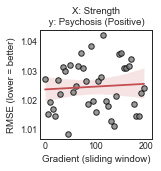

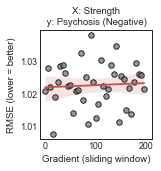

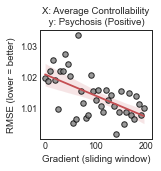

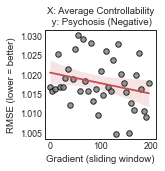

In [18]:
my_r = pd.DataFrame(index = metrics, columns = phenos)
my_pvals = pd.DataFrame(index = metrics, columns = phenos)

for m, metric in enumerate(metrics):
    for p, pheno in enumerate(phenos):
        print(metric, pheno)
        
        # Get X and y data
        if control_c == None:
            X = df_node.filter(regex = metric)
        else:
            X = df_node_ac_overc.filter(regex = metric + '_c' + str(control_c) + '_')
        print(X.shape)
        y = df_pheno.loc[:,pheno]; print(y.shape)

        # set regression estimator
        reg = copy.deepcopy(regs[alg])
    
        # sort and get cross-val
        X_sort, y_sort, my_cv, c_sort = get_stratified_cv(X = X, y = y, c = c, n_splits = n_splits)

        # get full model score
        nuis_model, _ = cross_val_score_nuis(X = X_sort, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
        if score == 'rmse': nuis_model = np.abs(nuis_model)
        main_score_nuis = nuis_model.mean()
        main_sterr_nuis = nuis_model.std() / np.sqrt(n_splits)
        print('Full model score:', main_score_nuis, main_sterr_nuis)
        
        print('Computing accuracy for non overlapping windows')
        # reorder X by gradient
        X_sort_grad = X_sort.iloc[:,sort_idx]
        
        window_start = np.arange(0,num_parcels - bin_size + 1, bin_size)
        num_windows = len(window_start)

        # compute accuracy for non overlapping windows
        window_score = np.zeros(num_windows,)
        window_sterr = np.zeros(num_windows,)

        for i, w in enumerate(window_start):
            Xl = X_sort_grad.iloc[:,w:w+bin_size]
            cv_results, _ = cross_val_score_nuis(X = Xl, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
            if score == 'rmse': cv_results = np.abs(cv_results)
            window_score[i] = cv_results.mean()
            window_sterr[i] = cv_results.std() / np.sqrt(n_splits)
            
        if metric == 'str':
            window_score_str = window_score.copy()
        elif metric == 'ac':
            window_score_ac = window_score.copy()
            
        # plot
        f, ax = plt.subplots()
        if control_c == None:
            f.set_figwidth(2)
            f.set_figheight(2)
        else:
            f.set_figwidth(1.25)
            f.set_figheight(1.25)
        sns.regplot(x = window_start, y = window_score, color = 'r', scatter = False)
        
        my_r.loc[metric,pheno] = sp.stats.pearsonr(window_start, window_score)[0]
        my_pvals.loc[metric,pheno] = sp.stats.pearsonr(window_start, window_score)[1]
        
        # non overlapping windows
        if len(window_start) > len(window_score): window_start = window_start[:len(window_score)]
        plt.scatter(x = window_start, y = window_score, marker = 'o', s = 30, edgecolors = 'black', facecolors = 'gray', alpha=0.8, linewidth = 1)
        ax.tick_params(pad = -2)

        ax.set_xlabel('Gradient (sliding window)')
        ax.set_ylabel('RMSE (lower = better)')
        ax.set_xlim([-10, num_parcels+10])
        if control_c != None:
            ax.set_ylim([0.995, 1.04])

        ax.set_title('X: ' + metrics_label[m] + '\n y: ' + phenos_label[p])

        if control_c == None:
            f.savefig('gradient_'+str(g)+'_window_'+metric+'_'+pheno+'.svg', dpi = 300, bbox_inches = 'tight')
        else:
            f.savefig('c_' + str(control_c) + '_gradient_'+str(g)+'_window_'+metric+'_'+pheno+'.svg', dpi = 300, bbox_inches = 'tight')

In [19]:
my_r

,Psychosis_Positive,Psychosis_NegativeDisorg
str,0.0680691,0.0577813
ac,-0.574395,-0.25512


In [20]:
my_pvals

,Psychosis_Positive,Psychosis_NegativeDisorg
str,0.67643,0.723227
ac,0.000106268,0.112112
